# AdaBoost classifier (1.5 points)

In this assignment, your task is to train an AdaBoost classifier on synthetic data. For reference, you are  provided with the posterior $P(y=1 \mid x)$, with $x$ regularly sampled over the domain $\mathcal{X} = [0,1]\times[0,1]$, so that you can see, in the end, how the output of the AdaBoost classifier better approximates the posterior at each round.

Please read the assignment entirely before you start coding, in order to get a sense of how it is organized. In particular, note that the AdaBoost algorithm is only run at the <a href='#AdaBoost-algorithm'>very last cell</a> of the 'Train the classifier' section. Before that, a number of functions are defined, one of which you need to complete.

 - <a href='#Train-the-classifier'>Question 1</a> (1.) Fill in the missing parts to implement the Adaboost algorithm described in class (slide 64 of the course). This involves iterating over the following steps:
  - <a href='#Finding-the-best-weak-learner'>a.</a> Find the best weak learner $h_t$ at each round.
  - <a href='#AdaBoost-algorithm'>b.</a> Using the weak learner's weighted error $\epsilon_t$, compute $\alpha_t$.
  - <a href='#AdaBoost-algorithm'>c.</a> Update the weight distribution $D_t$ of the training samples.
 - <a href='#Visualize-loss-function'>Question 2</a> (.3) Modify your loop to compute the loss $E_t = E(f(\mathbf{x}),\mathbf{y}) = \sum_{i=1}^{N} \exp(-y^i f(x^i))$ at each round. Then, plot $E_t$ and make sure that it is monotonically decreasing with time. Verify that $E_t$ provides an upper bound for the number of errors.
 - <a href='#Visualize-strong-learner-progress'>Question 3</a> (.2) First show the approximate posterior of your strong learner side-by-side with the original posterior. Then, show the approximate posteriors for each step at which the learner's response has been saved. Make sure that they look increasingly similar to the original posterior.
 
A word on notation:
 - The *response* of a weak learner $h$ for the sample $x$ is $h(x) \in \{-1,1\}$.
 - At each round we find the best weak learner, $h_t$, and define $f_t = \alpha_t h_t$. The *overall response* of the strong learner at round $t$ for the sample $x$, then, is $f(x) = \sum_t f_t(x) \in [-1,1]$ (note that we have an interval this time).  
 In order to be coherent with the weak learner's expression, we can also define $H(x) = \text{sign}(f(x)) \in \{-1,1\}$, which can also be called the *overall response*. However, in this assignment, we are only interested in $f$.

# Code

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import *
from construct_data import construct_data

## Visualize training data and posterior

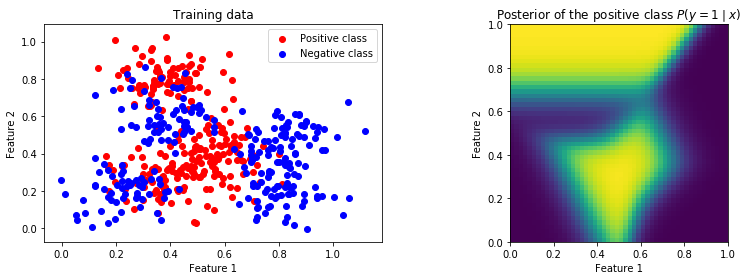

In [2]:
features, labels, posterior = construct_data(500, 'train', 'nonlinear', plusminus=True)

# Extract features for both classes
features_pos = features[labels == 1]
features_neg = features[labels != 1]

# Display data
fig = plt.figure(figsize=plt.figaspect(0.3))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(features_pos[:, 0], features_pos[:, 1], c="red", label="Positive class")
ax.scatter(features_neg[:, 0], features_neg[:, 1], c="blue", label="Negative class")

ax.set_title("Training data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.imshow(posterior, extent=[0, 1, 0, 1], origin='lower')
ax.set_title("Posterior of the positive class $P(y=1 \mid x)$")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")


plt.show()

<a id='train-the-classifier'></a>

## Train the classifier

### Weak learner evaluation

The weak learner we use for this classification problem is a *decision stump* (cf. slide 63 of the course), whose response is defined as $h(x) =  s (2[x_{d}\geq\theta] - 1)$, where 
 - $d$ is the the dimension along which the decision is taken, 
 - $[\cdot]$ is 1 if $\cdot$ is true and 0 otherwise, 
 - $\theta$ is the threshold applied along dimension $d$ and 
 - $s\in\{-1,1\}$ is the polarity of the decision stump (this is a multiplicative factor, not a function!).

For example, if $s = 1$, the decision stump will consider that all samples whose $d$-th feature is greater than $\theta$ are in the positive class ($h(x)=+1$), and all samples with a feature strictly lower than $\theta$ are in the negative class ($h(x)=-1$).

In [3]:
def evaluate_stump(features, coordinate_wl, polarity_wl, theta_wl):
    """Evaluate the stump's response for each point."""
    feature_slice = features[:, coordinate_wl]
    weak_learner_output = polarity_wl * (2*(feature_slice >= theta_wl) - 1)

    return weak_learner_output


def evaluate_stump_on_grid(x_rng, y_rng, coordinate_wl, polarity_wl, theta_wl):
    """Evaluate the stump's response for each point on a rectangular grid."""
    feature_slice = np.meshgrid(x_rng, y_rng)[coordinate_wl]
    weak_learner_on_grid = polarity_wl * (2*(feature_slice >= theta_wl) - 1)

    return weak_learner_on_grid

### Finding the best weak learner

At each round of AdaBoost, the samples are reweighted, thus producing a new classification problem, where the samples with a larger weigth count more in the classification error. The first step of a new round is to find the weak learner with the best performance for this new problem, that is, with the smallest classification error: 
$$\epsilon_t = \min_t \epsilon, \quad \text{with} \quad \epsilon = \sum_{i=1}^{N} D^i_t[y^i \neq h(x^i)].$$

Notes on the implementation:
 - The error is normalized in the course's slides, but in practice you don't need to, since the weights themselves are already normalized in the main loop of the algorithm.
 - When searching for the best weak learner, you don't need to consider all possible combinations of $\theta,d,s$. For a given dimension $d$, the relevant $\theta$ values to try are the $x^i_d$ (where $i$ indexes the training samples).

In [4]:
def find_best_weak_learner(weights, features, labels):
    """Find the best decision stump for the given weight distribution.
    
    Returns
    -------
    coordinate_wl : int
      Dimension 'd' along which the threshold is applied.
    polarity_wl : {-1, 1}
      Polarity 's' of the decision stump.
    theta_wl : float
      Threshold 'theta' for the decision.
    err_wl : float
      Weighted error for the decision stump.
      

    """
    coordinate_wl = 0
    polarity_wl = 1
    theta_wl = 0.
    err_wl = np.inf

    # TODO (Question 1)
    dataMatrix = mat(features)
    labelMat = mat(labels).T
    m,n = shape(dataMatrix)
    numSteps = 15
    bestClasEst = mat(zeros((m,1)))
    # Loop over all dimensions
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax-rangeMin)/numSteps
        # Loop over all range in current dimension
        for j in range(-1,int(numSteps)+1):
            # Go over less than and greater than
            for inequal in ['lt', 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = mat(ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                # Calculate total error multiplied by weights
                weightedError= weights.T*errArr
                if np.sum(weightedError) < err_wl:
                    err_wl= np.sum(weightedError)
                    bestClasEst = predictedVals.copy()
                    coordinate_wl = i
                    theta_wl = threshVal
                if inequal=='lt':
                    polarity_wl=-1.0
                else:
                    polarity_wl=1.0
    # /TODO (Question 1)

    return coordinate_wl, polarity_wl, theta_wl, err_wl, bestClasEst
    
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    retArray = ones((shape(dataMatrix)[0],1))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

### AdaBoost algorithm

In [5]:
npoints = features.shape[0]
num_rounds_boosting = 400

# Initialize arrays.
weights = mat(ones((npoints,1)) / npoints)  # Weight distribution on samples

## TODO (Question 1)
aggClassEst = mat(zeros((npoints,1)))
E=np.zeros(num_rounds_boosting)
## /TODO (Question 1)

f_on_grid = 0  # Used to plot function
x_rng = y_rng = np.linspace(0, 1, 50)

for i in range(num_rounds_boosting):

    ## TODO (Question 1)
    # Find best weak learner at current round of boosting.
    coordinate_wl, polarity_wl, theta_wl, err_wl, ClasEst= find_best_weak_learner(weights, features, labels)
    
    # Estimate alpha.
    # Calculate alpha, throw in max(error,eps) to account for error=0
    alpha = float(0.5*log((1.0-err_wl)/max(err_wl,1e-16)))
    
    # Reweight samples.
    # Exponent for weights calculation
    expon = multiply(-1*alpha*mat(labels).T,ClasEst)
    # Calculate new weights for next iteration
    weights= multiply(weights,exp(expon))                              
    weights= weights/weights.sum()
    ## /TODO (Question 1)


    ## TODO (Question 2)
    # Compute overall response at current round.
    # Calculate training error of all classifiers, if this is 0 quit for loop early (use break)
    aggClassEst += alpha*ClasEst
    #print("aggClassEst: ",aggClassEst.T)
    aggErrors = multiply(sign(aggClassEst) != mat(labels).T,ones((npoints,1)))
    errorRate = aggErrors.sum()/npoints
    #print("total error: ",errorRate)
    if errorRate == 0.0:
        break

    # Compute loss at current round.
    for j in range(len(labels)):
        E[i]+=np.exp(-sum(labels[j]*aggClassEst[j]))
    #print (E[i])
    ## /TODO (Question 2)

    # Evaluate f on a grid to produce the images.
    weak_learner_on_grid = evaluate_stump_on_grid(x_rng, y_rng, coordinate_wl, polarity_wl, theta_wl)
    f_on_grid += alpha*weak_learner_on_grid
    # Save gridded f at specific iterations.
    if i == 10:
        f_10 = f_on_grid.copy()
    elif i == 50:
        f_50 = f_on_grid.copy()
    elif i == 100:
        f_100 = f_on_grid.copy()

## Visualize loss function

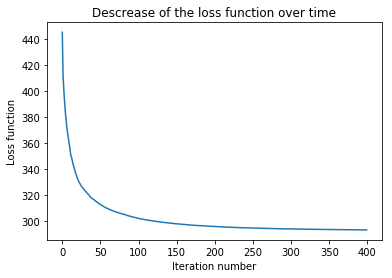

In [6]:
## TODO (Question 2)

fig, ax = plt.subplots()
ax.plot(E)
ax.set_title("Descrease of the loss function over time")
ax.set_xlabel("Iteration number")
ax.set_ylabel("Loss function")

## /TODO (Question 2)

plt.show()

## Visualize strong learner progress

It can be shown (cf. slide 69 of the course\*) that the AdaBoost strong classifier's response converges to half the *posterior log-ratio*:

$$\sum_{t=1}^\infty f_t(x) = \frac{1}{2} \log \left( \frac{P(y=1 \mid x)}{P(y=-1 \mid x)} \right),$$

which leads to an interesting method to approximate the posterior using the strong learner's response:

$$P(y=1 \mid x) \approx \frac{1}{1+\exp(-2f(x))}.$$

Therefore, we can check how good the response gets in terms of approximating the posterior.

<small>\*NB: There is a typo in this slide, the $\frac{1}{2}$ is missing.</small>

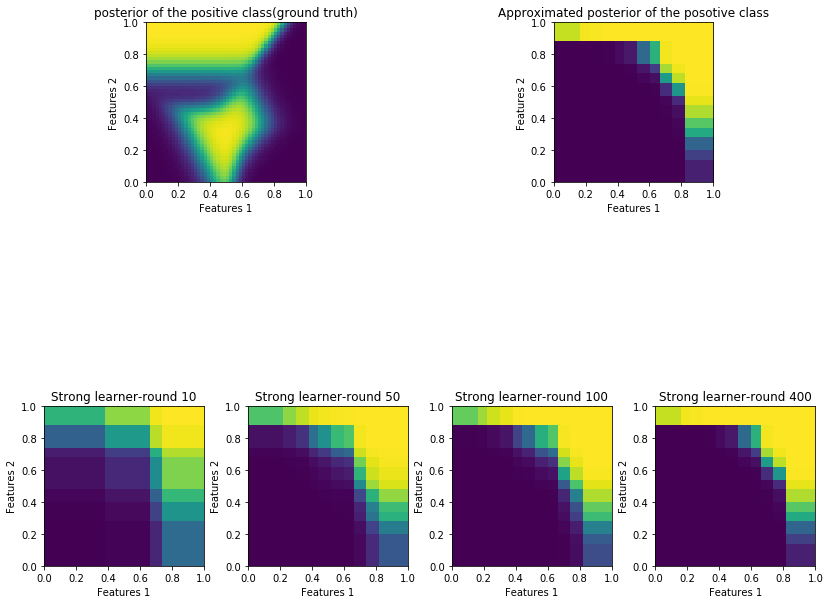

In [7]:
approx_posterior_10 = 1 / (1 + np.exp(-2 * f_10))
approx_posterior_50 = 1 / (1 + np.exp(-2 * f_50))
approx_posterior_100 = 1 / (1 + np.exp(-2 * f_100))
approx_posterior_400 = 1/ (1 + np.exp(-2 * f_on_grid))

# TODO (Question 3)
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(3,4,(1,2))
ax.set_title("posterior of the positive class(ground truth)")
ax.set_xlabel("Features 1")
ax.set_ylabel("Features 2")
ax.imshow(posterior,extent=[0,1,0,1],origin='lower')

ax = fig.add_subplot(3,4,(3,4))
ax.set_title("Approximated posterior of the posotive class")
ax.set_xlabel("Features 1")
ax.set_ylabel("Features 2")
ax.imshow(approx_posterior_400,extent=[0,1,0,1],origin='lower')

ax = fig.add_subplot(3, 4, 9)
ax.set_title("Strong learner-round 10")
ax.set_xlabel("Features 1")
ax.set_ylabel("Features 2")
ax.imshow(approx_posterior_10,extent=[0,1,0,1],origin='lower')

ax = fig.add_subplot(3, 4, 10)
ax.set_title("Strong learner-round 50")
ax.set_xlabel("Features 1")
ax.set_ylabel("Features 2")
ax.imshow(approx_posterior_50,extent=[0,1,0,1],origin='lower')

ax = fig.add_subplot(3, 4, 11)
ax.set_title("Strong learner-round 100")
ax.set_xlabel("Features 1")
ax.set_ylabel("Features 2")
ax.imshow(approx_posterior_100,extent=[0,1,0,1],origin='lower')

ax = fig.add_subplot(3, 4, 12)
ax.set_title("Strong learner-round 400")
ax.set_xlabel("Features 1")
ax.set_ylabel("Features 2")
ax.imshow(approx_posterior_400,extent=[0,1,0,1],origin='lower')
# /TODO (Question 3)

plt.show()